In [1]:
import numpy as np
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import csv
import os
import torchvision.transforms as transforms
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

device: cuda


***FOR ONLY HANDWRITTEN***

In [2]:
def load_mapping(file_path):
    mapping = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '=' not in line:
                continue
            key, value = line.split('=')
            key = key.strip()
            value = value.strip().lower().replace('0x', '')
            mapping[key] = chr(int(value, 16))
    return mapping

# Load your map
mapping = load_mapping('../../MOLHW/ASCII2Unicode.txt')

# Build vocab only from mapped characters
unique_chars = sorted(set(mapping.values()))  # Ensure unique + sorted

# Start vocab with special tokens
vocab = ["<blank>", "<pad>", "<unk>", " "] + unique_chars

# Create mappings
idx2char = {idx: char for idx, char in enumerate(vocab)}
char2idx = {char: idx for idx, char in idx2char.items()}

# Define padding token
PAD_TOKEN = 1

# Text to IDs function
def text_to_ids(text, max_length=None):

    # Convert Unicode to IDs, use <unk> for unknown characters
    ids = [char2idx.get(char, char2idx["<unk>"]) for char in text]

    # Pad or truncate if needed
    if max_length is not None:
        if len(ids) < max_length:
            ids += [PAD_TOKEN] * (max_length - len(ids))
        else:
            ids = ids[:max_length]

    return ids

# IDs to text function
def ids_to_text(ids):
    decoded_text = []
    for idx in ids:
        if idx == 0:
            continue  # Skip <blank>
        elif idx > 0:
            decoded_text.append(idx2char.get(idx, ''))
    return "".join(decoded_text)

In [3]:
#mn_ocr word by word
# folder_path = "../../dataset/qa_words/data.json"
folder_path = "../../dataset/MOLHW_unicode/dataset_adiya/MOLHW_unicode/data.json"
image_paths = []
image_labels = []

with open(folder_path) as f:
    data = json.load(f)

for el in data:
    image_paths.append(f"../../dataset/MOLHW_unicode/dataset_adiya/MOLHW_unicode/{el['path'].replace("\\", '/')}")
    image_labels.append(''.join(mapping.get(char, '') for char in el['label']))

In [4]:
class MongolianTextImageDataset(Dataset):
    def __init__(self, image_paths, labels, max_text_length=50, transform=None, pad_text=True):
        """
        Initializes the dataset.
        :param image_paths: List of paths to the image files.
        :param labels: List of corresponding text labels.
        :param max_text_length: Maximum length of text sequences. Padding will be applied if enabled.
        :param transform: Optional transformation to apply to the images.
        :param pad_text: Whether to pad text sequences to max_text_length.
        """
        self.image_paths = image_paths
        self.labels = labels
        self.max_text_length = max_text_length
        self.transform = transform
        self.pad_text = pad_text
        self.pad_token = char2idx.get("<pad>", PAD_TOKEN)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Fetches an image and its corresponding text.

        :param idx: Index of the image-text pair.
        :return: Tuple (image_tensor, text_ids) where text_ids is a tensor of token indices.
        """
        # Load image
        image = Image.open(self.image_paths[idx]).convert('RGB')

        # Apply the transformation to the image (if any)
        if self.transform:
            image = self.transform(image)

        text = self.labels[idx]
        # Convert text to token IDs
        text_ids = text_to_ids(text)

        # Apply padding or truncation if enabled
        if self.pad_text:
            if len(text_ids) < self.max_text_length:
                text_ids.extend([self.pad_token] * (self.max_text_length - len(text_ids)))  # Pad
            else:
                text_ids = text_ids[:self.max_text_length]  # Truncate

        return image, torch.tensor(text_ids, dtype=torch.long)


In [5]:

input_shape = (32, 256)

transform = transforms.Compose([
    transforms.Lambda(lambda img: img.rotate(90, expand=True)),  # Rotate 90 degrees
    transforms.Resize(input_shape),
    transforms.Grayscale(num_output_channels=1),  # Converts to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0], std=[1]),  # Adjusted to single channel
])

# Split dataset into train and validation sets (80% train, 20% validation)
train_dataset, val_dataset = train_test_split(list(zip(image_paths, image_labels)), test_size=0.1, random_state=42)

# mini_size = 100

# train_dataset = train_dataset[:mini_size]
# val_dataset = val_dataset[:mini_size]

# Create datasets for training and validation
train_dataset = MongolianTextImageDataset([item[0] for item in train_dataset], [item[1] for item in train_dataset], max_text_length=20, transform=transform, pad_text=True)
val_dataset = MongolianTextImageDataset([item[0] for item in val_dataset], [item[1] for item in val_dataset], max_text_length=20, transform=transform, pad_text=True)

# Create DataLoaders for batching
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
eval_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

*Shows how it transforms image for model*

c:\Users\adiya\miniconda3\envs\mn-ocr\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6181 (\N{MONGOLIAN LETTER OE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\adiya\miniconda3\envs\mn-ocr\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6177 (\N{MONGOLIAN LETTER E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\adiya\miniconda3\envs\mn-ocr\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6199 (\N{MONGOLIAN LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\adiya\miniconda3\envs\mn-ocr\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6188 (\N{MONGOLIAN LETTER QA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\adiya\miniconda3\envs\mn-ocr\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 6182 (\N{MONGOLIAN LETTER UE}) missing

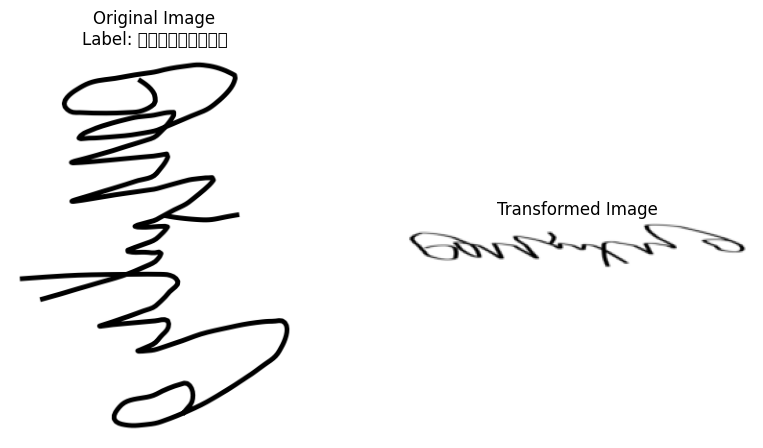

In [28]:
idx = random.randint(0, len(image_paths) - 1)
random_image_path = image_paths[idx]
random_label = image_labels[idx]

# Load original image
original_image = Image.open(random_image_path)

transformed_image = transform(original_image)

# Convert transformed tensor back to image for visualization
def tensor_to_pil(tensor):
    # Undo normalization
    tensor = tensor.clone()
    tensor = tensor.squeeze(0)  # remove channel dim (C=1)
    tensor = tensor.mul(1).add(0)  # (undo mean=0, std=1)
    tensor = torch.clamp(tensor, 0, 1)  # clip values to [0,1]
    return transforms.ToPILImage()(tensor)

pil_transformed_image = tensor_to_pil(transformed_image)

# Show both original and transformed images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Original
axs[0].imshow(original_image)
axs[0].set_title(f'Original Image\nLabel: {random_label}')
axs[0].axis('off')

# Transformed
axs[1].imshow(pil_transformed_image, cmap='gray')
axs[1].set_title('Transformed Image')
axs[1].axis('off')

plt.show()

In [2]:
class CRNN(nn.Module):
    def __init__(self, input_channels=1, hidden_dim=256, dropout_rate=0.25):
        """
        Initializes the CRNN model with added dropout layers.
        
        :param input_channels: Number of input channels (e.g., 1 for grayscale).
        :param hidden_dim: Hidden dimension size for the RNN.
        :param dropout_rate: Dropout rate for preventing overfitting.
        """
        super(CRNN, self).__init__()
        self.num_classes = len(idx2char)  # Number of output classes

        # CNN feature extractor with dropout
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0)

        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm5 = nn.BatchNorm2d(512)
        self.batchnorm7 = nn.BatchNorm2d(512)

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1))
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1))

        # Dropout after CNN layers
        self.dropout_cnn = nn.Dropout2d(dropout_rate)

        # BiLSTM for sequence modeling
        self.rnn = nn.LSTM(input_size=512 * 1, hidden_size=hidden_dim, num_layers=2,
                           bidirectional=True, batch_first=True)

        # Dropout after BiLSTM
        self.dropout_rnn = nn.Dropout(dropout_rate)

        # Fully connected layer to map RNN outputs to num_classes
        self.fc = nn.Linear(hidden_dim * 2, self.num_classes)  # *2 for bidirectional

        # Dropout after the fully connected layer
        # self.dropout_fc = nn.Dropout(dropout_rate)

    def forward(self, x):
        """
        Forward pass.
        
        :param x: Input image tensor of shape (batch_size, channels, height, width)
        :return: Logits of shape (batch_size, seq_length, num_classes)
        """
        # Convolutional feature extraction
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.batchnorm3(self.conv3(x)))
        x = self.pool3(F.relu(self.conv4(x)))
        x = F.relu(self.batchnorm5(self.conv5(x)))
        x = self.pool4(F.relu(self.conv6(x)))
        x = F.relu(self.batchnorm7(self.conv7(x)))

        # Dropout after CNN layers
        x = self.dropout_cnn(x)

        # Reshape to fit into RNN
        b, c, h, w = x.shape
        x = x.permute(0, 3, 1, 2)  # (batch_size, width, channels, height)
        x = x.reshape(b, w, c * h)  # Flatten channels and height

        # Pass through BiLSTM
        rnn_out, _ = self.rnn(x)

        # Dropout after RNN
        rnn_out = self.dropout_rnn(rnn_out)

        # Fully connected layer for character prediction
        logits = self.fc(rnn_out)  # Shape: (batch_size, seq_length, num_classes)

        # Dropout after the fully connected layer
        # logits = self.dropout_fc(logits)

        return logits


In [6]:
def decode_predictions(predictions):
    """
    Decode model predictions to text strings.
    
    Args:
        predictions: Tensor of indices
    
    Returns:
        List of decoded strings
    """
    texts = []
    for pred in predictions:
        # Get the highest probability character at each timestep
        pred_indices = torch.argmax(pred, dim=1).cpu().numpy()
        
        # Remove repeated characters
        collapsed = []
        prev = -1
        for p in pred_indices:
            if p != prev and p != 0:  # Skip blanks
                collapsed.append(p)
            prev = p
        
        # Convert indices to characters
        text = ''.join([idx2char.get(idx, '') for idx in collapsed if idx != 1])  # Skip pad tokens
        texts.append(text)
    return texts

def calculate_wer(reference, hypothesis): #new to be tried later
    """
    Calculate Word Error Rate (WER) using dynamic programming.
    
    Args:
        reference: List of ground truth strings
        hypothesis: List of predicted strings
    
    Returns:
        Word Error Rate as a float
    """
    total_words = 0
    total_errors = 0

    for ref, hyp in zip(reference, hypothesis):
        ref_words = ref.split()
        hyp_words = hyp.split()
        total_words += len(ref_words)

        # Initialize DP table
        dp = [[0] * (len(hyp_words) + 1) for _ in range(len(ref_words) + 1)]

        # Fill first row and column
        for i in range(len(ref_words) + 1):
            dp[i][0] = i  # Deletions
        for j in range(len(hyp_words) + 1):
            dp[0][j] = j  # Insertions

        # Compute edit distance
        for i in range(1, len(ref_words) + 1):
            for j in range(1, len(hyp_words) + 1):
                if ref_words[i - 1] == hyp_words[j - 1]:
                    dp[i][j] = dp[i - 1][j - 1]  # No change
                else:
                    dp[i][j] = 1 + min(
                        dp[i - 1][j],    # Deletion
                        dp[i][j - 1],    # Insertion
                        dp[i - 1][j - 1] # Substitution
                    )

        # Final WER count
        total_errors += dp[-1][-1]  # Minimum edit distance

    return total_errors / total_words if total_words > 0 else 0


def calculate_cer(reference, hypothesis):
    """
    Calculate Character Error Rate without external libraries.
    
    Args:
        reference: List of ground truth strings
        hypothesis: List of predicted strings
    
    Returns:
        Character Error Rate as a float
    """
    total_chars = 0
    char_errors = 0
    
    for ref, hyp in zip(reference, hypothesis):
        total_chars += len(ref)
        
        # Simplified Levenshtein distance calculation
        # Initialize matrix
        matrix = [[0 for _ in range(len(hyp) + 1)] for _ in range(len(ref) + 1)]
        
        # Initialize first row and column
        for i in range(len(ref) + 1):
            matrix[i][0] = i
        for j in range(len(hyp) + 1):
            matrix[0][j] = j
        
        # Fill matrix
        for i in range(1, len(ref) + 1):
            for j in range(1, len(hyp) + 1):
                if ref[i-1] == hyp[j-1]:
                    matrix[i][j] = matrix[i-1][j-1]
                else:
                    matrix[i][j] = min(
                        matrix[i-1][j] + 1,      # deletion
                        matrix[i][j-1] + 1,      # insertion
                        matrix[i-1][j-1] + 1     # substitution
                    )
        
        char_errors += matrix[len(ref)][len(hyp)]
    
    return char_errors / total_chars if total_chars > 0 else 0


In [24]:
input_channels = 1  # Grayscale
model = CRNN( input_channels=input_channels)

# Example input (batch_size=8, channels=1, height=128, width=512)
input_shape = (32, 256)
input_tensor = torch.randn(8, input_channels, input_shape[0], input_shape[1])
output = model(input_tensor)

print("Output shape:", output.shape)  # Expected: (8, seq_length, num_classes)

Output shape: torch.Size([8, 65, 163])


In [7]:
class CNN_Transformer(nn.Module):
    def __init__(self, input_channels=1, hidden_dim=256, dropout_rate=0.25, num_heads=8, num_layers=6):
        """
        Initializes the CNN + Transformer model for OCR.
        
        :param input_channels: Number of input channels (e.g., 1 for grayscale).
        :param hidden_dim: Hidden dimension size for the transformer.
        :param dropout_rate: Dropout rate for preventing overfitting.
        :param num_heads: Number of attention heads in the transformer.
        :param num_layers: Number of transformer encoder layers.
        :param num_classes: Number of output classes (characters).
        """
        super(CNN_Transformer, self).__init__()
        self.num_classes = len(idx2char)  # Number of output classes

        # CNN feature extractor with dropout
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0)

        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm5 = nn.BatchNorm2d(512)
        self.batchnorm7 = nn.BatchNorm2d(512)

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1))
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1))

        # Dropout after CNN layers
        self.dropout_cnn = nn.Dropout2d(dropout_rate)

        # Transformer Encoder layer
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim*2, nhead=num_heads, dropout=dropout_rate),
            num_layers=num_layers
        )

        # Fully connected layer to map transformer outputs to num_classes
        self.fc = nn.Linear(hidden_dim*2, self.num_classes)

    def forward(self, x):
        """
        Forward pass.
        
        :param x: Input image tensor of shape (batch_size, channels, height, width)
        :return: Logits of shape (batch_size, seq_length, num_classes)
        """
        # Convolutional feature extraction
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.batchnorm3(self.conv3(x)))
        x = self.pool3(F.relu(self.conv4(x)))
        x = F.relu(self.batchnorm5(self.conv5(x)))
        x = self.pool4(F.relu(self.conv6(x)))
        x = F.relu(self.batchnorm7(self.conv7(x)))

        # Dropout after CNN layers
        x = self.dropout_cnn(x)

        # Reshape to fit into Transformer (batch_size, width, channels, height) -> (batch_size, seq_length, hidden_dim)
        b, c, h, w = x.shape
        x = x.permute(0, 3, 1, 2)  # (batch_size, width, channels, height)
        x = x.reshape(b, w, c * h)  # Flatten channels and height into one dimension

        # Pass through Transformer Encoder
        transformer_out = self.transformer_encoder(x)

        # Pass through fully connected layer for character prediction
        logits = self.fc(transformer_out)  # Shape: (batch_size, seq_length, num_classes)

        return logits


In [ ]:
# model = CNN_Transformer( input_channels=1)
# total_params = sum(p.numel() for p in model.parameters())
# print(f"Total parameters: {total_params}")

# # Count only trainable parameters
# trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"Trainable parameters: {trainable_params}")

Total parameters: 24549283
Trainable parameters: 24549283


In [8]:

input_channels = 1  # Grayscale
model = CNN_Transformer( input_channels=input_channels, dropout_rate=0.1)
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
ctc_loss_fn = nn.CTCLoss(blank=0, zero_infinity=True)

num_epochs = 5
loss_history = []
val_loss_history = []
wer_history = []
cer_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_idx, (images, targets) in enumerate(train_dataloader):
        # Move images and targets to device (GPU or CPU)
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.permute(1, 0, 2)
        outputs = torch.log_softmax(outputs, dim=2)
        batch_size = images.size(0)
        seq_length = outputs.size(0)
        input_lengths = torch.full((batch_size,), seq_length, dtype=torch.long, device=device)

        target_lengths = (targets != 1).sum(dim=1).to(device)

        flattened_targets = []
        for i in range(batch_size):
            non_pad = targets[i][targets[i] != 1]
            flattened_targets.extend(non_pad.tolist())
        flattened_targets = torch.tensor(flattened_targets, dtype=torch.long, device=device)

        loss = ctc_loss_fn(outputs, flattened_targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Batch Logging
        if (batch_idx + 1) % 50 == 0 or batch_idx == len(train_dataloader) - 1:
            print(f"Batch {batch_idx+1}/{len(train_dataloader)}, "
                  f"Batch Loss: {loss.item():.4f}, Running Loss: {epoch_loss / (batch_idx+1):.4f}")

    loss_history.append(epoch_loss / len(train_dataloader))

    # Validation loop with WER and CER calculation
    model.eval()
    val_loss = 0.0
    all_ground_truth = []
    all_predictions = []
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(eval_dataloader):
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            outputs = outputs.permute(1, 0, 2)
            outputs = torch.log_softmax(outputs, dim=2) 
            batch_size = images.size(0)
            seq_length = outputs.size(0)
            input_lengths = torch.full((batch_size,), seq_length, dtype=torch.long, device=device)

            target_lengths = (targets != 1).sum(dim=1).to(device)

            flattened_targets = []
            for i in range(batch_size):
                non_pad = targets[i][targets[i] != PAD_TOKEN]
                flattened_targets.extend(non_pad.tolist())
            flattened_targets = torch.tensor(flattened_targets, dtype=torch.long, device=device)

            val_loss += ctc_loss_fn(outputs, flattened_targets, input_lengths, target_lengths).item()
            
            # Decode predictions
            pred_texts = decode_predictions(outputs.permute(1, 0, 2))
            
            # Decode ground truth
            gt_texts = []
            for i in range(batch_size):
                gt = targets[i][targets[i] != 1].cpu().numpy()
                gt_text = ''.join([idx2char.get(idx, '') for idx in gt if idx != 1])
                gt_texts.append(gt_text)
            
            all_ground_truth.extend(gt_texts)
            all_predictions.extend(pred_texts)



    val_loss_history.append(val_loss / len(eval_dataloader))
    # print(all_ground_truth, all_predictions)
    # Calculate WER
    epoch_wer = calculate_wer(all_ground_truth, all_predictions)
    
    # Calculate CER
    epoch_cer = calculate_cer(all_ground_truth, all_predictions)
    
    wer_history.append(epoch_wer)
    cer_history.append(epoch_cer)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_dataloader):.4f}, "
          f"Val Loss: {val_loss / len(eval_dataloader):.4f}, WER: {epoch_wer:.4f}, CER: {epoch_cer:.4f}")


model_name = 'transformers_160k_5_epoch'

torch.save(model.state_dict(), f'models/{model_name}.pth')

# Combine your history data into a list of rows
history_data = list(zip(range(1, len(loss_history) + 1), loss_history, val_loss_history, wer_history, cer_history))

# Define CSV file path
csv_file_path = f'train_history/{model_name}.csv'

# Write to CSV
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'WER', 'CER'])  # Write header
    writer.writerows(history_data)  # Write history data

print(f"Training history saved to {csv_file_path}")

c:\Users\adiya\miniconda3\envs\mn-ocr\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Batch 50/2316, Batch Loss: 3.1102, Running Loss: 4.0452
Batch 100/2316, Batch Loss: 2.9802, Running Loss: 3.5345
Batch 150/2316, Batch Loss: 2.8848, Running Loss: 3.3445
Batch 200/2316, Batch Loss: 2.8298, Running Loss: 3.2367
Batch 250/2316, Batch Loss: 2.7521, Running Loss: 3.1547
Batch 300/2316, Batch Loss: 2.7115, Running Loss: 3.0896
Batch 350/2316, Batch Loss: 2.7054, Running Loss: 3.0339
Batch 400/2316, Batch Loss: 2.5384, Running Loss: 2.9848
Batch 450/2316, Batch Loss: 2.6301, Running Loss: 2.9443
Batch 500/2316, Batch Loss: 2.4947, Running Loss: 2.9053
Batch 550/2316, Batch Loss: 2.4660, Running Loss: 2.8701
Batch 600/2316, Batch Loss: 2.5810, Running Loss: 2.8390
Batch 650/2316, Batch Loss: 2.2653, Running Loss: 2.8104
Batch 700/2316, Batch Loss: 2.2377, Running Loss: 2.7732
Batch 750/2316, Batch Loss: 2.1445, Running Loss: 2.7251
Batch 800/2316, Batch Loss: 1.8782, Running Loss: 2.6749
Batch 850/2316, Batch Loss: 1.7981, Running Loss: 2.6268
Batch 900/2316, Batch Loss: 1.81

In [ ]:
import csv

model_name = 'transformers_160k_10_epoch'

torch.save(model.state_dict(), f'models/{model_name}.pth')

# Combine your history data into a list of rows
history_data = list(zip(range(1, len(loss_history) + 1), loss_history, val_loss_history, wer_history, cer_history))

# Define CSV file path
csv_file_path = f'train_history/{model_name}.csv'

# Write to CSV
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'WER', 'CER'])  # Write header
    writer.writerows(history_data)  # Write history data

print(f"Training history saved to {csv_file_path}")



Training history saved to train_history/transformers_160k_10_epoch.csv


In [ ]:
# epochs = []
# loss_history = []
# val_loss_history = []
# wer_history = []
# cer_history = []

# # Read the CSV file
# with open(csv_file_path, mode='r') as file:
#     reader = csv.reader(file)
#     header = next(reader)  # Skip the header row
#     for row in reader:
#         # Append values to corresponding lists
#         epochs.append(int(row[0]))0/
#         loss_history.append(float(row[1]))
#         val_loss_history.append(float(row[2]))
#         wer_history.append(float(row[3]))
#         cer_history.append(float(row[4]))

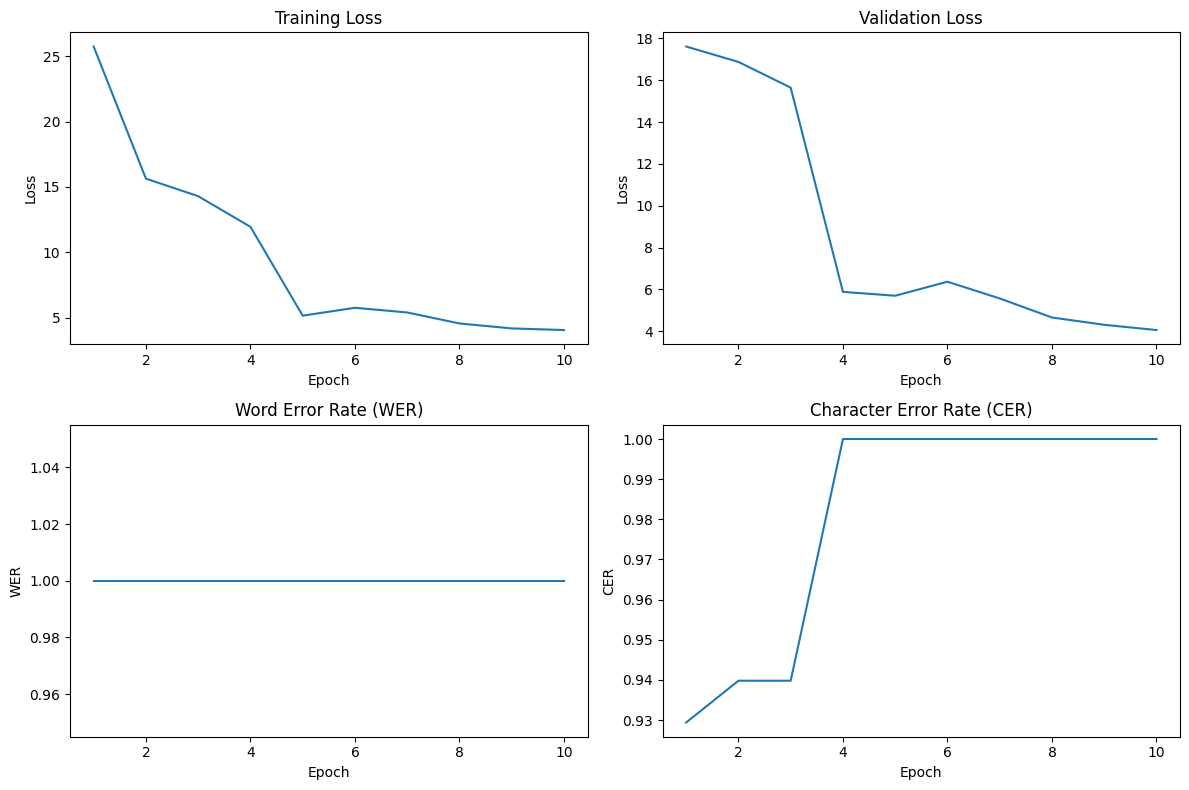

In [55]:
plt.figure(figsize=(12, 8))
n = len(loss_history)
plt.subplot(2, 2, 1)
plt.plot(range(1, n+1), loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 2)
plt.plot(range(1, n+1), val_loss_history)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(range(1, n+1), wer_history)
plt.title('Word Error Rate (WER)')
plt.xlabel('Epoch')
plt.ylabel('WER')

plt.subplot(2, 2, 4)
plt.plot(range(1, n+1), cer_history)
plt.title('Character Error Rate (CER)')
plt.xlabel('Epoch')
plt.ylabel('CER')

plt.tight_layout()
plt.savefig('ocr_metrics.png')
plt.show()

In [13]:
# Save the model's state_dict
torch.save(model.state_dict(), 'models/cnn_transformer_model_20k_10epoch.pth')


**FOR TESTING MODEL**

In [10]:
# Load the saved model (if not already loaded)
model = CRNN(input_channels=1)
model.load_state_dict(torch.load('models/crnn_model_10k_100epoch.pth'))
model = model.to(device)  # Make sure the model is on the correct device

In [ ]:
image_path = 'test_images/0a0ab9d5aed94bb5b79bbbc51e7be418.png'
image = Image.open(image_path)
input_shape = (32, 256)
transform = transforms.Compose([
    transforms.Resize(input_shape),
    transforms.Grayscale(num_output_channels=1),  # Converts to grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0], std=[1]),  # Adjusted to single channel
])
input_tensor = transform(image)
input_tensor = input_tensor.unsqueeze(0).to(device)  # Move to CUDA
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(input_tensor)
pred_texts = decode_predictions(output)
pred_texts


In [ ]:
# Load the saved model (if not already loaded)
model = CRNN(input_channels=input_channels)
model.load_state_dict(torch.load('crnn_model.pth'))
model = model.to(device)  # Make sure the model is on the correct device

# Set the model to evaluation mode
model.eval()

# Initialize variables to track loss, WER, and CER
val_loss = 0.0
all_ground_truth = []
all_predictions = []

with torch.no_grad():
    # Iterate over the evaluation dataset
    for batch_idx, (images, targets) in enumerate(eval_dataloader):
        images = images.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(images)
        outputs = outputs.permute(1, 0, 2)
        outputs = torch.log_softmax(outputs, dim=2)

        batch_size = images.size(0)
        seq_length = outputs.size(0)
        input_lengths = torch.full((batch_size,), seq_length, dtype=torch.long, device=device)
        target_lengths = (targets != 1).sum(dim=1).to(device)

        flattened_targets = []
        for i in range(batch_size):
            non_pad = targets[i][targets[i] != 1]
            flattened_targets.extend(non_pad.tolist())
        flattened_targets = torch.tensor(flattened_targets, dtype=torch.long, device=device)

        # Calculate CTC loss
        val_loss += ctc_loss_fn(outputs, flattened_targets, input_lengths, target_lengths).item()

        # Decode predictions
        pred_texts = decode_predictions(outputs.permute(1, 0, 2))

        # Decode ground truth
        gt_texts = []
        for i in range(batch_size):
            gt = targets[i][targets[i] != 1].cpu().numpy()
            gt_text = ''.join([idx2char.get(idx, '') for idx in gt if idx != 1])
            gt_texts.append(gt_text)

        all_ground_truth.extend(gt_texts)
        all_predictions.extend(pred_texts)

# Calculate WER
epoch_wer = calculate_wer(all_ground_truth, all_predictions)

# Calculate CER
epoch_cer = calculate_cer(all_ground_truth, all_predictions)

# Print the results
print(f"Validation Loss: {val_loss / len(eval_dataloader):.4f}")
print(f"WER: {epoch_wer:.4f}")
print(f"CER: {epoch_cer:.4f}")


Validation Loss: 1.9177
WER: 0.8095
CER: 0.4467


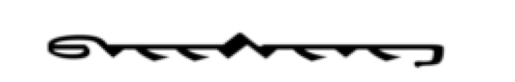

In [82]:

image_tensor = images[0].cpu()

# Step 1: Remove the channel dimension (1, 32, 256) -> (32, 256)
image_tensor = image_tensor.squeeze(0)  # Removes the first dimension if it's 1

# Step 2: Convert the tensor to a NumPy array
image_np = image_tensor.numpy()

# Step 3: Display the image using Matplotlib
plt.imshow(image_np, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.axis('off')  # Hide axes
plt.show()

In [18]:
loss_history

[10.443752334231423,
 3.3523581103673057,
 2.971088377256242,
 2.1956395487936717,
 1.4581397346087865,
 1.056591988082916,
 0.7395082489838676,
 0.6356182706261438,
 0.4741916907212091,
 0.4096931258127803,
 0.31977434799311655,
 0.29637891905648367,
 0.2613030942896056,
 0.2171793563498391,
 0.2036448320935643,
 0.19376554464300474,
 0.17796317192297134,
 0.17132153764130578,
 0.186450448064577,
 0.20502694672535335,
 0.1594695526485642,
 0.1347256990607887,
 0.12584854748159174,
 0.12118428986933497,
 0.11891715175339154,
 0.14008671246350757,
 0.11532117420482257,
 0.12074003414443088,
 0.10498758186660116,
 0.11289987662836673,
 0.09544602766751296,
 0.10119873861826602,
 0.09774624254731905,
 0.08910074961253457,
 0.08340144890641409,
 0.08428826832419468,
 0.078923886789689,
 0.07971082897191602,
 0.07514874230227656,
 0.08728247156573667,
 0.2021101281224262,
 0.10793870140517516,
 0.13228612818888255,
 0.11023158509106863,
 0.0944212894177153,
 0.08082242035085246,
 0.07818456